# Pytorch Workflow

1.  Data (prepare and load)
2.  Build model
3.  Fitting the model to data (training)
4.  Making predictions and evaluating a model
5.  Saving and loading a model
6.  Putting it all together



In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for model
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

## 1. Data can be anything


In [2]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10],

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})





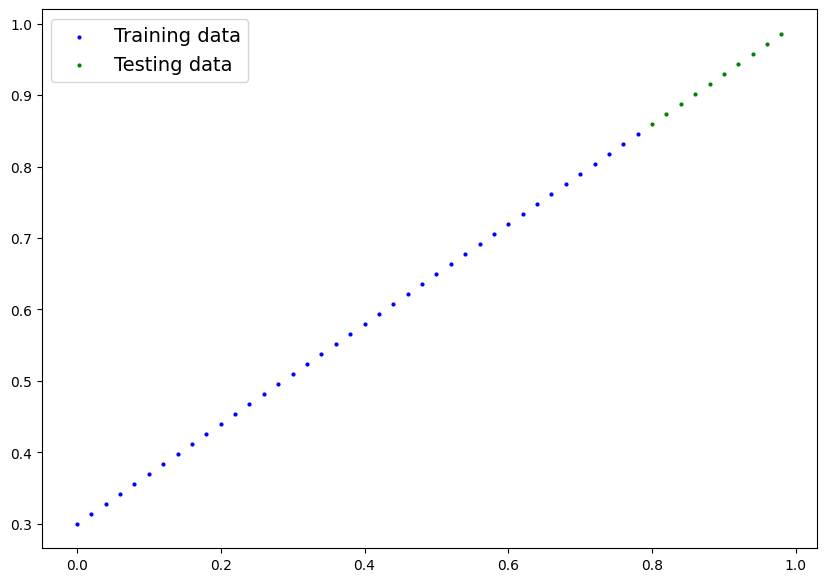

In [6]:
plot_predictions();

# Build PyTorch model

Python OOP folow the link: https://realpython.com/python3-object-oriented-programming/

In [7]:
# Create linear regression model class
class LinearRegresssionModel(nn.Module): # almost everything in PyTorch inherit from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    # forward method to define the computation in the model

  def forward(self, x:torch.Tensor) -> torch.Tensor:
      return self.weights * x + self.bias

How does it work
Through two main algorithms

1. Gradient descent
2. Backpropagation

In [8]:
# create a random seed
model_0 = LinearRegresssionModel()
list(model_0.parameters())


[Parameter containing:
 tensor([1.3591], requires_grad=True),
 Parameter containing:
 tensor([-0.6885], requires_grad=True)]

In [9]:
# list named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([1.3591])), ('bias', tensor([-0.6885]))])

In [10]:
# Making predictions
with torch.inference_mode():
  y_preds = model_0(X_test)


y_preds

tensor([[0.3987],
        [0.4259],
        [0.4531],
        [0.4803],
        [0.5075],
        [0.5346],
        [0.5618],
        [0.5890],
        [0.6162],
        [0.6434]])

In [11]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

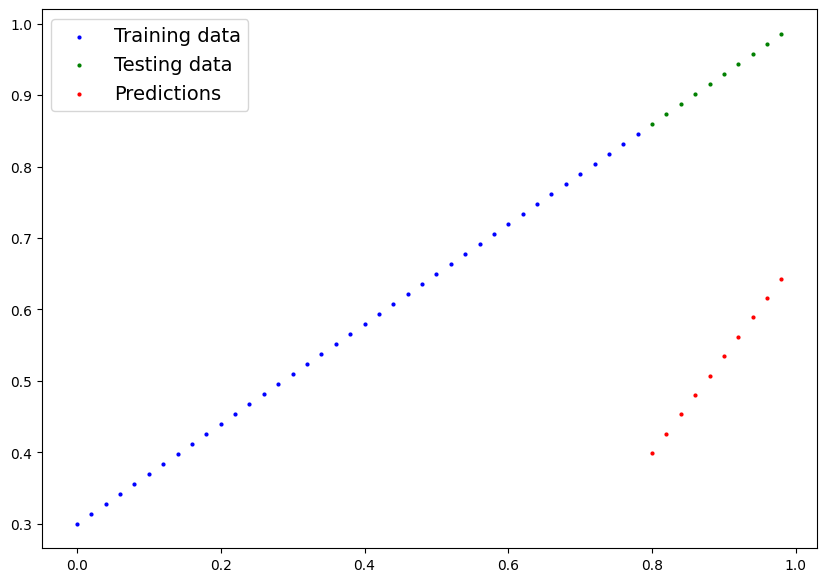

In [12]:
plot_predictions(predictions=y_preds);

Woah! Those predictions look pretty bad...

This makes sense though, when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the green dots.

Time to change that.

### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The rolls of these are:

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function.

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)).

Woah, that's a lot, let's see it in code.

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([1.3591], requires_grad=True),
 Parameter containing:
 tensor([-0.6885], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([1.3591])), ('bias', tensor([-0.6885]))])

In [15]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Building a traning loop (and a testing loop ) in pytorch
A couple of things we need in a traing loop :
0. Loop through the data
1. Forward pass ( this involves moving through our model's forward() function) to make predictions on data- also called forward propagation
2. Calculate the loss( compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameter of our model with respect to the loss (***backpropagation***)
5. optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss(***gradient descent***)

In [16]:
torch.manual_seed(42)
# An epoch is one loop through the data...
epochs=100

### Training

# Loop through the data
for epoch in range(epochs):
  # set the model to training mood
  model_0.train() # train mood in pytorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)


  # 3. Optimizer  zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so...we have to zero them above in step 3 for the next iteration of the loop
  ### Testing
  model_0.eval()
  test_preds = model_0(X_test)
  test_loss = loss_fn(test_preds, y_test)
  if epoch %10 == 0:
   print(f"Epoch: {epoch} | Loss:{loss} | Test loss:{test_loss}")
   print(model_0.state_dict())



Epoch: 0 | Loss:0.7314777374267578 | Test loss:0.3884788453578949
OrderedDict([('weights', tensor([1.3630])), ('bias', tensor([-0.6785]))])
Epoch: 10 | Loss:0.6162676215171814 | Test loss:0.2537685036659241
OrderedDict([('weights', tensor([1.4020])), ('bias', tensor([-0.5785]))])
Epoch: 20 | Loss:0.501057505607605 | Test loss:0.11905813217163086
OrderedDict([('weights', tensor([1.4410])), ('bias', tensor([-0.4785]))])
Epoch: 30 | Loss:0.38584738969802856 | Test loss:0.04056838899850845
OrderedDict([('weights', tensor([1.4800])), ('bias', tensor([-0.3785]))])
Epoch: 40 | Loss:0.27793511748313904 | Test loss:0.14363014698028564
OrderedDict([('weights', tensor([1.5159])), ('bias', tensor([-0.2825]))])
Epoch: 50 | Loss:0.2235819399356842 | Test loss:0.2273419350385666
OrderedDict([('weights', tensor([1.5324])), ('bias', tensor([-0.2135]))])
Epoch: 60 | Loss:0.19744546711444855 | Test loss:0.28061535954475403
OrderedDict([('weights', tensor([1.5367])), ('bias', tensor([-0.1640]))])
Epoch: 7

In [17]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([1.5033])), ('bias', tensor([-0.0640]))])

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([1.5033])), ('bias', tensor([-0.0640]))])

In [20]:
weight, bias

(0.7, 0.3)

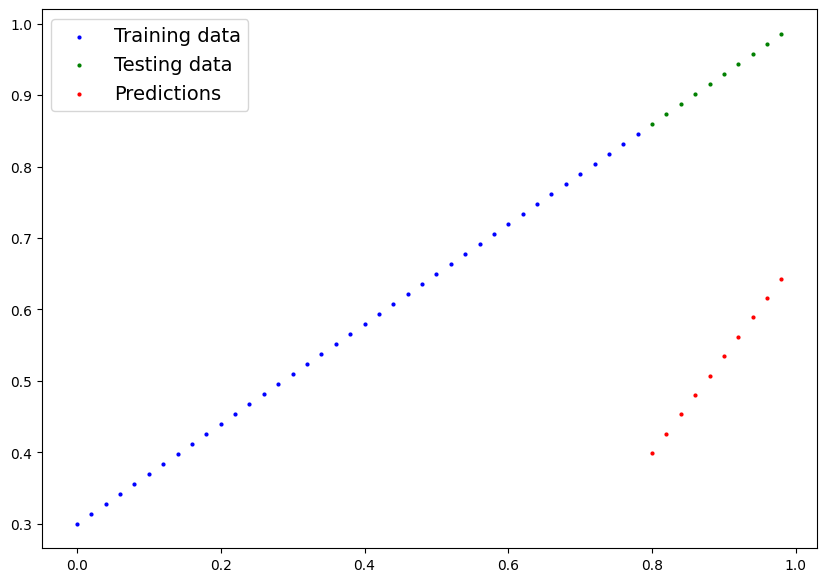

In [21]:
plot_predictions(predictions=y_preds);

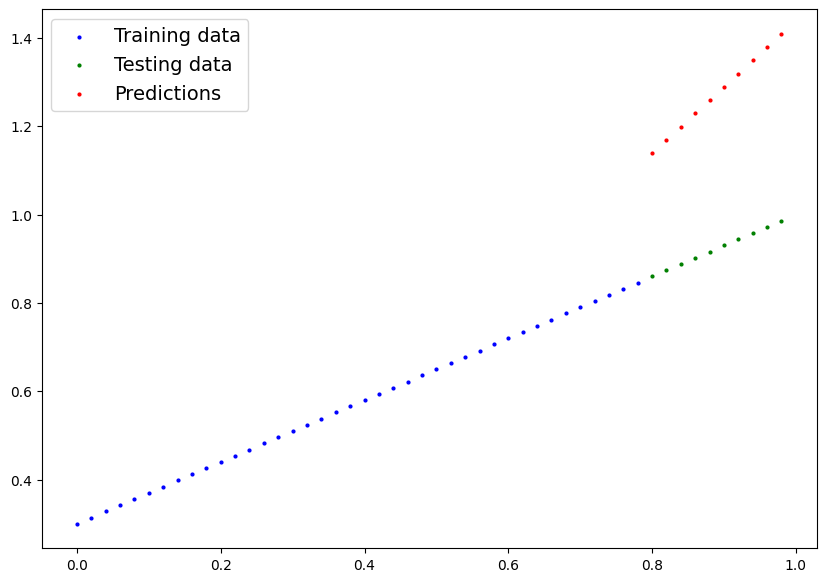

In [22]:
plot_predictions(predictions=y_preds_new);